In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
from scipy.stats import qmc

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Building ANN
class Net(nn.Module):
    def __init__(self, n_layers=20, n_nodes=64):
        super().__init__()
        self.fcin = nn.Linear(2, n_nodes)
        self.hidden = nn.ModuleList([nn.Linear(n_nodes,n_nodes) for i in range(n_layers)])
        self.fcout = nn.Linear(n_nodes, 3)

    def forward(self, x):
        x = torch.tanh(self.fcin(x))
        for layers in self.hidden:
            x = torch.tanh(layers(x))
        x = self.fcout(x)
        
        u = x[:,0].view(len(x[:,0]),1)
        v = x[:,1].view(len(x[:,1]),1)
        p = x[:,2].view(len(x[:,2]),1)

        return u, v, p

# Auto Differentiation
def derivatives(u, v, p, coords):
    size = torch.ones(u.size()).to(device)
    
    du = grad(u, coords, grad_outputs=size, create_graph=True, allow_unused=True)[0]
    dv = grad(v, coords, grad_outputs=size, create_graph=True, allow_unused=True)[0]
    dp = grad(p, coords, grad_outputs=size, create_graph=True, allow_unused=True)[0]

    u_x = du[:,0].view(len(du[:,0]),1)
    u_y = du[:,1].view(len(du[:,1]),1)

    v_x = dv[:,0].view(len(dv[:,0]),1)
    v_y = dv[:,1].view(len(dv[:,1]),1)
    
    p_x = dp[:,0].view(len(dp[:,0]),1)
    p_y = dp[:,1].view(len(dp[:,1]),1)
    
    du_x = grad(u_x, coords, grad_outputs=size, create_graph=True, allow_unused=True)[0]
    du_y = grad(u_y, coords, grad_outputs=size, create_graph=True, allow_unused=True)[0]

    dv_x = grad(v_x, coords, grad_outputs=size, create_graph=True, allow_unused=True)[0]
    dv_y = grad(v_y, coords, grad_outputs=size, create_graph=True, allow_unused=True)[0]
    
    u_xx = du_x[:,0].view(len(du_x[:,0]),1)
    u_yy = du_y[:,1].view(len(du_y[:,1]),1)

    v_xx = dv_x[:,0].view(len(dv_x[:,0]),1)
    v_yy = dv_y[:,1].view(len(dv_y[:,1]),1)
    
    return u_x, u_y, v_x, v_y, p_x, p_y, u_xx, u_yy, v_xx, v_yy

# Latin hypercube sampler
def lhs(n, samples, seed=None):
    sampler = qmc.LatinHypercube(d=n, seed=seed)
    return sampler.random(n=samples)

In [4]:
class Cylinder:
    def __init__(self, fluid_points=10000):
        ### Create data points
        self.lb = -1 #Left bound
        self.rb = 3 #Right bound
        self.tb = 1 #Top bound
        self.bb = -1 #Bottom bound

        left = [self.lb,self.bb] + [0.0, self.tb-self.bb] * lhs(2, 200)
        top = [self.lb,self.tb] + [self.rb-self.lb, 0.0] * lhs(2,200)
        bottom = [self.lb,self.bb] + [self.rb-self.lb, 0.0] * lhs(2,200)

        self.INLET = np.concatenate((left,top,bottom), axis = 0)

        theta = np.linspace(0, 360, 180)
        cylinder_x = 0.1*np.cos(theta*np.pi/180)
        cylinder_y = 0.1*np.sin(theta*np.pi/180)
        cylinder_x = cylinder_x.flatten()[:, None]
        cylinder_y = cylinder_y.flatten()[:, None]
        
        self.WALL = np.concatenate((cylinder_x, cylinder_y), axis = 1)

        fluid = ([self.lb, self.bb] + [self.rb-self.lb, self.tb-self.bb] * lhs(2,fluid_points)).tolist()
        # fluid_refined = ([-0.2, -0.2] + [0.4, 0.4] * lhs(2,int(0.1*fluid_points))).tolist()
        # fluid = fluid + fluid_refined

        fluid_boolean = []

        for point in fluid:
            if point[0]**2 + point[1]**2 <= 0.1**2:
                fluid_boolean.append(False)
            elif point[0] == -0.2:
                fluid_boolean.append(False)
            else:
                fluid_boolean.append(True)        

        FLUID = []
        for i in range(len(fluid_boolean)):
            if fluid_boolean[i]:
                FLUID.append(fluid[i])
        self.FLUID = np.array(FLUID)
        
        ### Define boundary conditions
        self.inlet_velocity = 1.0
        self.angle_of_attack = 0
        self.inlet_target_u = torch.ones(len(self.INLET),1).to(device)
        self.inlet_target_v = torch.zeros(len(self.INLET),1).to(device)
        self.inlet_zero_target = torch.zeros(len(self.INLET),1).to(device)
        self.wall_zero_target = torch.zeros(len(self.WALL),1).to(device)
        self.fluid_zero_target = torch.zeros(len(self.FLUID),1).to(device)
        
    def plot_domain(self):
        # Visualise Points
        fig, ax = plt.subplots(figsize = (15, 15))
        plt.scatter(np.array(self.WALL)[:,0],np.array(self.WALL)[:,1], s = 0.5)
        plt.scatter(np.array(self.INLET)[:,0],np.array(self.INLET)[:,1], s = 0.5)
        plt.scatter(np.array(self.FLUID)[:,0],np.array(self.FLUID)[:,1], s = 0.5)
        ax.set_aspect('equal', adjustable='box')
        
        plt.show()
        
    def send_to_device(self, device):
        self.INLET = torch.tensor(self.INLET, requires_grad=True, dtype=torch.float32).to(device)
        self.FLUID = torch.tensor(self.FLUID, requires_grad=True, dtype=torch.float32).to(device)
        self.WALL = torch.tensor(self.WALL, requires_grad=True, dtype=torch.float32).to(device)
        

In [5]:
# Define PINN
class PINN:
    def __init__(self, domain, device, n_layers=20, n_nodes=64, lr=1e-5):
        self.domain = domain
        self.model = Net(n_layers=n_layers, n_nodes=n_nodes).to(device)
        self.model.apply(self.init_weights)
        
        self.optimizer_adam = optim.Adam(self.model.parameters(), lr=lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), lr=lr)
        
        self.domain.send_to_device(device)
        
    def loss_fn(self):
        MSEloss = nn.MSELoss()

        # Train Inlet
        # Foward Propagation
        u, v, p = self.model(self.domain.INLET)
        # Inlet Loss 
        loss_inlet = MSEloss(u, self.domain.inlet_target_u) + MSEloss(v, self.domain.inlet_target_v)

        # Train Wall
        # Foward Propagation
        u, v, p = self.model(self.domain.WALL)
        # Wall Loss
        loss_wall = MSEloss(u, self.domain.wall_zero_target) + MSEloss(v, self.domain.wall_zero_target)
        
        # Train Fluid
        # Foward Propagation
        u, v, p = self.model(self.domain.FLUID)
        u_x, u_y, v_x, v_y, p_x, p_y, u_xx, u_yy, v_xx, v_yy = derivatives(u, v, p, self.domain.FLUID)
        # Fluid Loss
        nu = 1e-2
        R_con = u_x + v_y  # Continuity
        R_xmom = u*u_x + v*u_y + p_x - nu*(u_xx + u_yy) # x momentum
        R_ymom = u*v_x + v*v_y + p_y - nu*(v_xx + v_yy) # y momentum     
        loss_fluid = MSEloss(R_con, self.domain.fluid_zero_target) + MSEloss(R_xmom, self.domain.fluid_zero_target) + MSEloss(R_ymom, self.domain.fluid_zero_target)
        
        return loss_inlet, loss_wall, loss_fluid
    
    def train(self):
        loss_inlet, loss_wall, loss_fluid = self.loss_fn()
        loss = loss_inlet + loss_wall + loss_fluid
        
        self.optimizer_adam.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer_adam.step()
        
        return loss_inlet.item(), loss_wall.item(), loss_fluid.item()
    
    def train_lbfgs(self):
        losses = {}

        def closure():
            loss_inlet, loss_wall, loss_fluid = self.loss_fn()
            self.optimizer_LBFGS.zero_grad()
            loss = loss_inlet + loss_wall + loss_fluid
            loss.backward()

            # Store losses for later access
            losses['inlet'] = loss_inlet.item()
            losses['wall'] = loss_wall.item()
            losses['fluid'] = loss_fluid.item()
            return loss

        self.optimizer_LBFGS.step(closure)
        return losses['inlet'], losses['wall'], losses['fluid']
    
    def predict(self, points):
        if not isinstance(points, torch.Tensor):
            points = torch.tensor(points, dtype=torch.float32).to(device)
        with torch.no_grad():
            u, v, p = self.model(points)

        return u.cpu().numpy(), v.cpu().numpy(), p.cpu().numpy()
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(0.01)

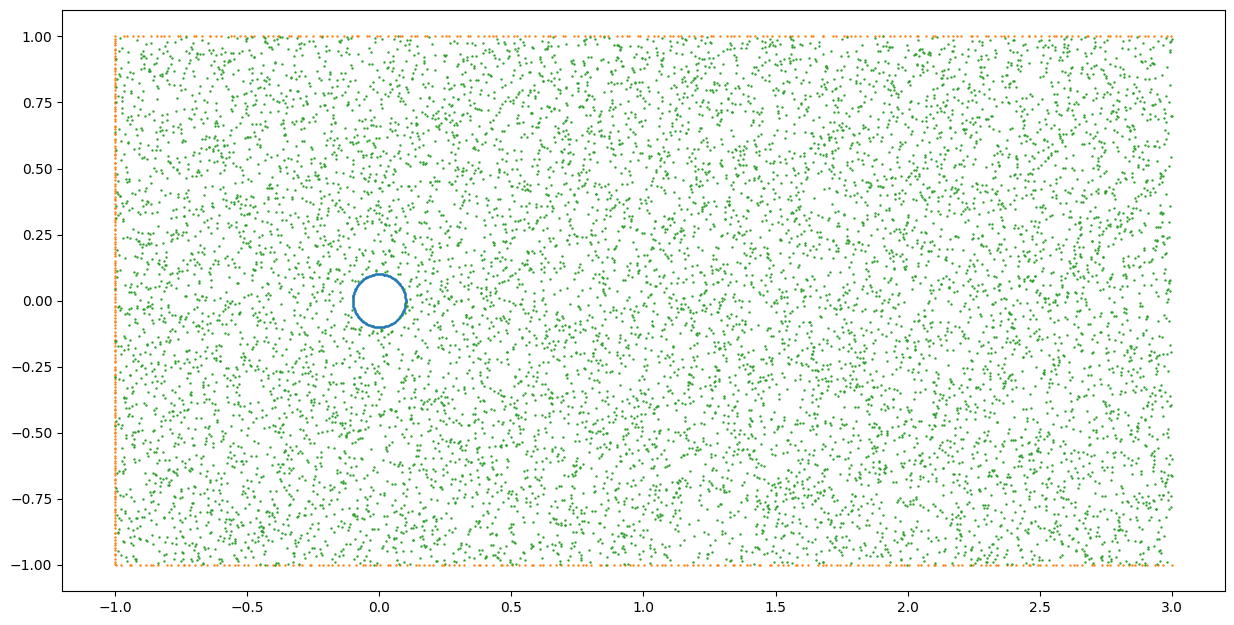

In [6]:
cylinder = Cylinder(fluid_points=10000)
cylinder.plot_domain()

In [7]:
# Train PINN
pinn = PINN(cylinder, device, n_layers=30, n_nodes=64, lr=1e-5)

inlet_losses = []
wall_losses = []
fluid_losses = []

EPOCH = 12000
for epoch in tqdm(range(EPOCH)):    

    if epoch < EPOCH - 10:
        loss_inlet, loss_wall, loss_fluid = pinn.train()
    else:
        loss_inlet, loss_wall, loss_fluid = pinn.train_lbfgs()
    
    # Convert to float and log
    inlet_losses.append(loss_inlet)
    wall_losses.append(loss_wall)
    fluid_losses.append(loss_fluid)


print('Training Done!')

100%|██████████| 12000/12000 [06:26<00:00, 31.08it/s]

Training Done!


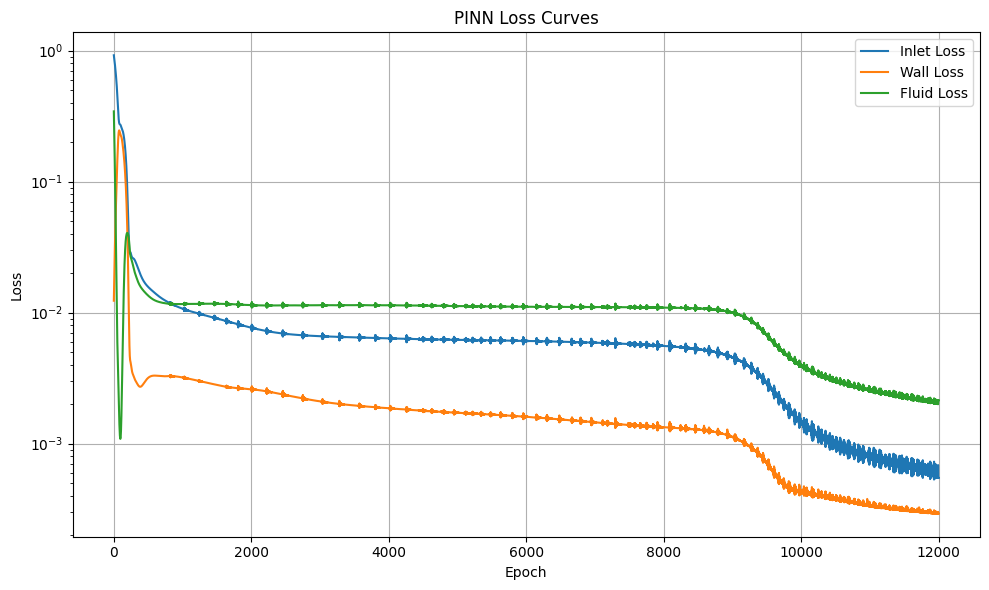

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(inlet_losses, label='Inlet Loss')
plt.plot(wall_losses, label='Wall Loss')
plt.plot(fluid_losses, label='Fluid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('PINN Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'p')

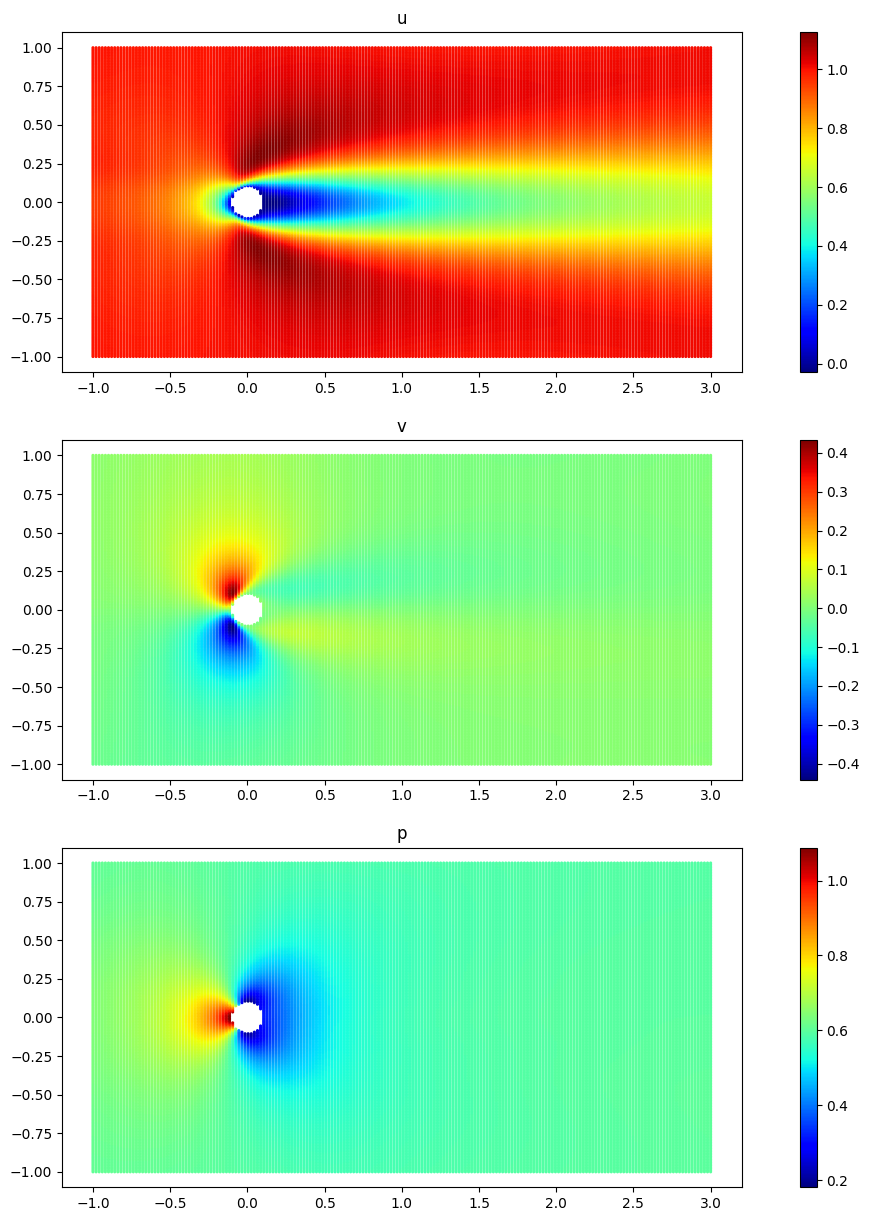

In [14]:
# Post Processing
x_POST = np.linspace(cylinder.lb, cylinder.rb, 200)
y_POST = np.linspace(cylinder.bb, cylinder.tb, 200)
x_POST, y_POST = np.meshgrid(x_POST, y_POST)
x_POST = x_POST.flatten()[:, None]
y_POST = y_POST.flatten()[:, None]

POST = np.concatenate((x_POST, y_POST), axis = 1)

bool_POST = []

for point in POST:
    if point[0]**2 + point[1]**2 <= 0.1**2:
        bool_POST.append(False)
    elif point[0] == -0.2:
        bool_POST.append(False)
    else:
        bool_POST.append(True)

COORDS = []
for i in range(len(bool_POST)):
    if bool_POST[i]:
        COORDS.append(POST[i])
COORDS = torch.tensor(COORDS, dtype=torch.float32).to(device)
# plt.scatter(COORDS[:,0], COORDS[:,1])

u_POST, v_POST, p_POST = pinn.predict(COORDS)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
cf = ax[0].scatter(COORDS[:,0].cpu(), COORDS[:,1].cpu(), c=u_POST, alpha=1, s=5, edgecolors='none', cmap='jet')
fig.colorbar(cf, ax=ax[0])
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_title('u')

cf = ax[1].scatter(COORDS[:,0].cpu(), COORDS[:,1].cpu(), c=v_POST, alpha=1, s=5, edgecolors='none', cmap='jet')
fig.colorbar(cf, ax=ax[1])
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_title('v')

cf = ax[2].scatter(COORDS[:,0].cpu(), COORDS[:,1].cpu(), c=p_POST, alpha=1, s=5, edgecolors='none', cmap='jet')
fig.colorbar(cf, ax=ax[2])
ax[2].set_aspect('equal', adjustable='box')
ax[2].set_title('p')

In [10]:
# torch.save(pinn.model.state_dict(), "CYLINDER.pth")